# Generative Models

*Disclaimer: This guide is in an early stage. We welcome contributions to the guide in form of issues and pull requests.*

From the perspective of BayesFlow, a generative model is more than just a prior (encoding beliefs about the parameters before observing data) and a data simulator (a likelihood function, often implicit, that generates data given parameters). 

In addition, a model consists of various implicit context assumptions, which we can make explicit at any time. Furthermore, we can also amortize over these context variables, thus making our real-world inference more flexible (i.e., applicable to more contexts). We are leveraging the concept of amortized inference and extending it to context variables as well.

The utilities for generative models are organized in the {py:mod}`~bayesflow.simulators` module.

## The `make_simulator` dispatch function

The simplest way to define a simulator is the {py:func}`~bayesflow.simulators.make_simulator` function. It supports a number of different signatures. The most important one just takes a list of functions, and turns them into a {py:class}`~bayesflow.simulators.SequentialSimulator`. Let's try it out:

In [24]:
import bayesflow as bf

In [27]:
def foo():
    return dict(a=5.0)

def bar(a):
    return dict(b=2*a)

simulator = bf.make_simulator([foo, bar])
print(type(simulator))

<class 'bayesflow.simulators.sequential_simulator.SequentialSimulator'>


We can now use the {py:meth}`~bayesflow.simulators.Simulator.sample` method to simulate a _batch_ of data.

In [30]:
data = simulator.sample(2)
print("Data:", data)
print("Shapes:", {k: v.shape for k, v in data.items()})

Data: {'a': array([[5.],
       [5.]]), 'b': array([[10.],
       [10.]])}
Shapes: {'a': (2, 1), 'b': (2, 1)}


As we can see from the output, the simulator has automatically combined the outputs of `foo` and `bar`. It has introduced a batch dimension, so that both outputs have the shape `(batch_size, 1)`. Note that there are limits to this. For example, if the length of `b` would be different for different samples, combining them into one array will fail. In this case, techniques like [padding](https://numpy.org/doc/stable/reference/generated/numpy.pad.html) can help to make them compatible again.

## Simulator Classes

BayesFlow provides a number of different simulator classes for different use cases.

### LambdaSimulator

{py:class}`~bayesflow.simulators.LambdaSimulator` is the simplest simulator. It wraps a single function that produces samples. The function can either produce a single sample per call (`is_batched=False`), or produce a whole batch per call (`is_batched=True`). While the former is often more convenient, the latter might be a lot faster if your simulator can effeciently produce many samples in parallel. Let's try both options for a simple simulator, which just produces samples from a uniform distribution. We start with the non-batched variant:

In [31]:
import numpy as np

In [36]:
rng = np.random.default_rng(seed=2025)
def simulation_fn():
    print("Calling the simulation_fn.")
    return {"x": rng.uniform()}

simulator = bf.simulators.LambdaSimulator(simulation_fn)
print(simulator.sample(2))

Calling the simulation_fn.
Calling the simulation_fn.
{'x': array([0.99445781, 0.38200974])}


Even though we only implemented how to obtain one sample, the simulator allows us to simulate a whole batch of data at once. It calls the provided function repeatedly and combines the outputs into a single dictionary.

For the batched function, we have to take a `batch_shape` as the first argument. It tells us how many samples we should produce, and which shape they should have. Here, we can simply pass it on to the `size` parameter of the {py:func}`~numpy.random.uniform` function. In addition, we have to tell the {py:class}`~bayesflow.simulators.LambdaSimulator` that we produce complete batches now, by setting `is_batched=True`.

In [39]:
rng = np.random.default_rng(seed=2025)
def batched_simulation_fn(batch_shape):
    print("Calling the batched_simulation_fn.")
    return {"x": rng.uniform(size=batch_shape)}

simulator = bf.simulators.LambdaSimulator(batched_simulation_fn, is_batched=True)
print(simulator.sample(2))

Calling the batched_simulation_fn.
{'x': array([0.99445781, 0.38200974])}


As expected, we see that the function is only called once, but produces the same output.

### SequentialSimulator

In many cases, there is a structure to the generative model we want to specify. In Bayesian inference, a very common one is the separation into the _prior_, which produces parameter values, and the _likelihood_, which produces data given for given parameter values. The {py:class}`~bayesflow.simulators.SequentialSimulator` provides an interface for such an information flow. It executes one Simulator after the other, and passes the combined outputs to the downstream ones. Note that it takes {py:class}`~bayesflow.simulators.Simulator`s as inputs, and not arbitrary functions. To create a {py:class}`~bayesflow.simulators.SequentialSimulator` from a list of functions, use {py:func}`~bayesflow.simulators.make_simulator`.

We will demonstrate it with a simple example:

In [44]:
rng = np.random.default_rng(seed=2025)
def prior():
    return {"loc": rng.normal(), "scale": rng.uniform()}

def likelihood(loc, scale):
    return {"x": rng.normal(loc=loc, scale=scale, size=3)}

simulator = bf.simulators.SequentialSimulator([
    bf.simulators.LambdaSimulator(prior),
    bf.simulators.LambdaSimulator(likelihood),
])
# short form: bf.make_simulator([prior, likelihood])
data = simulator.sample(2)
print("Data:", data)
print("Shapes:", {k: v.shape for k, v in data.items()})

Data: {'loc': array([[-2.22125388],
       [-0.53896902]]), 'scale': array([[0.38200974],
       [0.83725528]]), 'x': array([[-3.15407072, -1.9288669 , -2.51147025],
       [-0.31542505,  0.0486007 , -0.29438891]])}
Shapes: {'loc': (2, 1), 'scale': (2, 1), 'x': (2, 3)}


### ModelComparisonSimulator

This simulator will be covered in the chapter on model comparison.

## Rejection Sampling

In some settings, we might want to exclude simulations after sampling, for example because we can already tell that they are not plausible. Using the {py:meth}`~bayesflow.simulators.Simulator.rejection_sample` method, we can specify a `predicate` function to provide a mask for the samples we consider valid.

Let's make up a simple example. In our simulator, we generate two uniformly distributed values, `x` and `y`. We only want to accept samples that lie inside a circle with radius one, which gives the condition $\sqrt{x^2+y^2}\le1.$

In [53]:
rng = np.random.default_rng(seed=2025)
def simulator_fn():
    return {"x": rng.uniform(-1.5, 1.5), "y": rng.uniform(-1.5, 1.5)}

def predicate(data):
    return np.sqrt(data["x"]**2+data["y"]**2) <= 1.0

simulator = bf.make_simulator(simulator_fn)

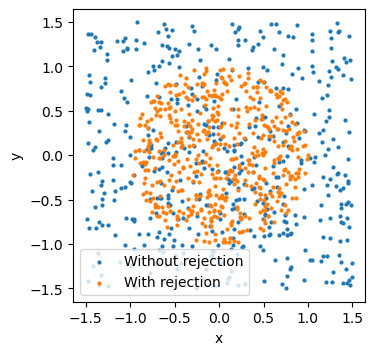

In [64]:
import matplotlib.pyplot as plt

samples = simulator.sample(500)
filtered_samples = simulator.rejection_sample(500, predicate=predicate, sample_size=100)
plt.figure(figsize=(3.8,3.8))
plt.scatter(samples["x"], samples["y"], s=4, label="Without rejection")
plt.scatter(filtered_samples["x"], filtered_samples["y"], s=4, label="With rejection")
plt.gca().set_aspect("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.legend();

In [65]:
print("Shapes without rejection:", {k: v.shape for k, v in samples.items()})
print("Shapes with rejection:", {k: v.shape for k, v in filtered_samples.items()})

Shapes without rejection: {'x': (500,), 'y': (500,)}
Shapes with rejection: {'x': (502,), 'y': (502,)}


The {py:meth}`~bayesflow.simulators.Simulator.rejection_sample` method automatically ensures that we get _at least_ the number of samples described in `batch_shape`. As the function produces `sample_size` samples before each filtering step, it will usually overshoot a bit, so that we get more samples than we requested. If this is not desired (e.g., for comparisons with a fixed number of training datasets), we have to discard the additional samples manually.

**Caution**: If you misspecify the predicate function, or it is too restrictive, sampling can take very long (or forever) until the desired number of samples is reached.

## Summary

BayesFlow offers convenient wrapper classes that allow combining functions into more complex generative models, as well as utilities for sampling. For more detailed information, take a look at the API documentation of the {py:mod}`~bayesflow.simulators` module.